In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


In [24]:
# Neuron parameters 
# Fountas, Zafeirios. "Action selection in the rhythmic brain: The role of the basal ganglia and tremor." PhD Thesis, Imperial College London (2016).

a = 0.01 / br.ms
b = -20 / br.ms
c = -55 * br.mV
d = 91 * br.mV / br.ms
vpeak = 40 * br.mV
vr = -80 * mV
vt = -29.7 * br.mV
C = 15.2 * br.pF 
v = -80 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
K = 0.0289
L = 0.331

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
        
sigma_msn = 14.0 * br.mV
N = 10000

In [18]:
# Neuron parameters 
# eNeuro

a = 0.2 / br.ms
b = 0.025 / br.ms
c = -60 * br.mV
d = 0 * br.mV / br.ms
vpeak = 25 * br.mV
vr = -64.4 * mV
vt = -50 * br.mV
C = 80 * br.pF 

v = 0 * br.mV
u = 0.0 * br.mV
K = 1

L = 0.331
Ispon = 0.0 * br.mV
KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
N = 10000

### Brian Example
- Brette_Gerstner_2005: adaptive exponential integrate and fire model 

INFO:root:building '_cython_magic_ca929bae6761cc489159210c279c2ecd' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_ca929bae6761cc489159210c279c2ecd.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_ca929bae6761cc489159210c279c2ecd.o -w

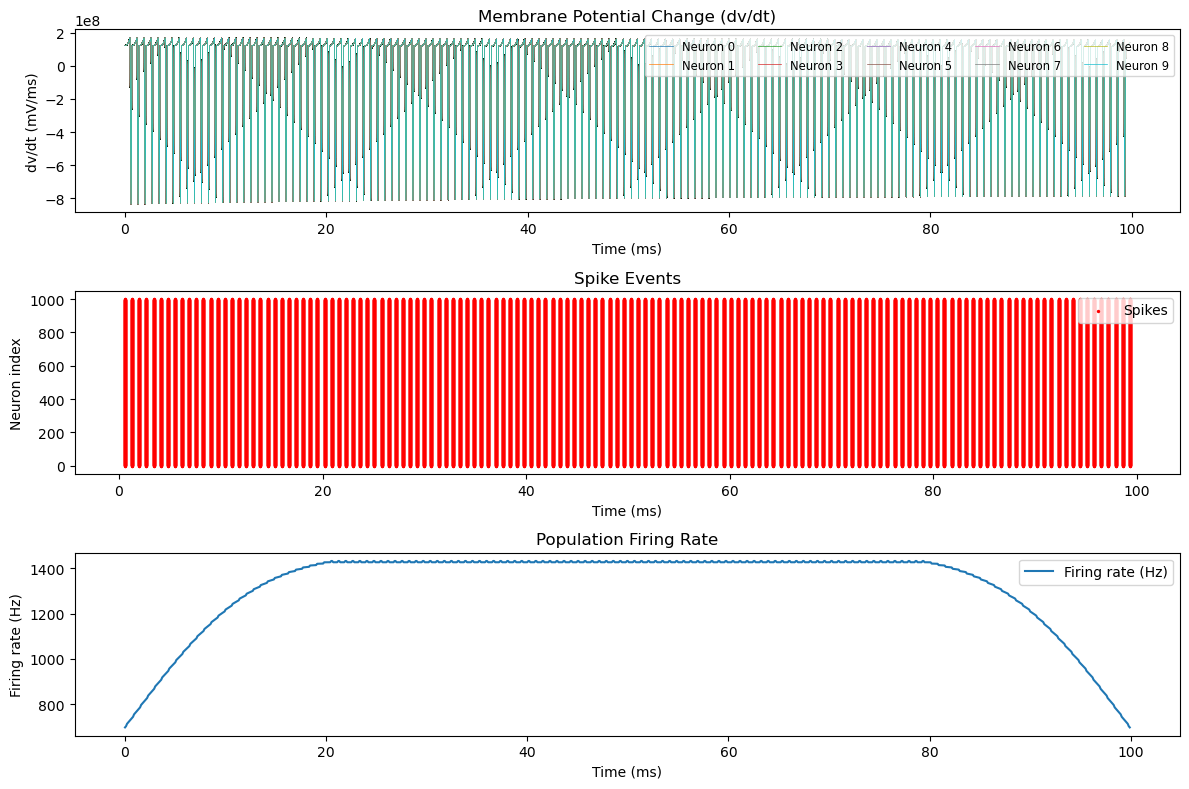

In [27]:
eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
dSPN.v = -65 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.02 / ms
dSPN.b = 0.2 / ms
dSPN.c = -65 * mV
dSPN.d = 8 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 30 * mV
dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time (ms)')
plt.ylabel('dv/dt (mV/ms)')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
spike_monitor.num_spikes

142000

In [7]:
### input from cortex

def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)  # 시간 배열 생성
    input_values = np.ones_like(t) * 20  # 기본 값으로 초기화
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
            
    return t * ms, input_values

dt = 0.1
defaultclock.dt = 1 * ms  # 시뮬레이션 시간 단계 설정
duration = 10000 * ms  # 시뮬레이션 시간 설정
t, cortex_input = generate_cortex_input(duration, defaultclock.dt)
input_array = TimedArray(cortex_input, dt=dt*ms)

INFO:root:building '_cython_magic_8dda32e976e9529ebc5645bf1af6002f' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_8dda32e976e9529ebc5645bf1af6002f.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_8dda32e976e9529ebc5645bf1af6002f.o -w

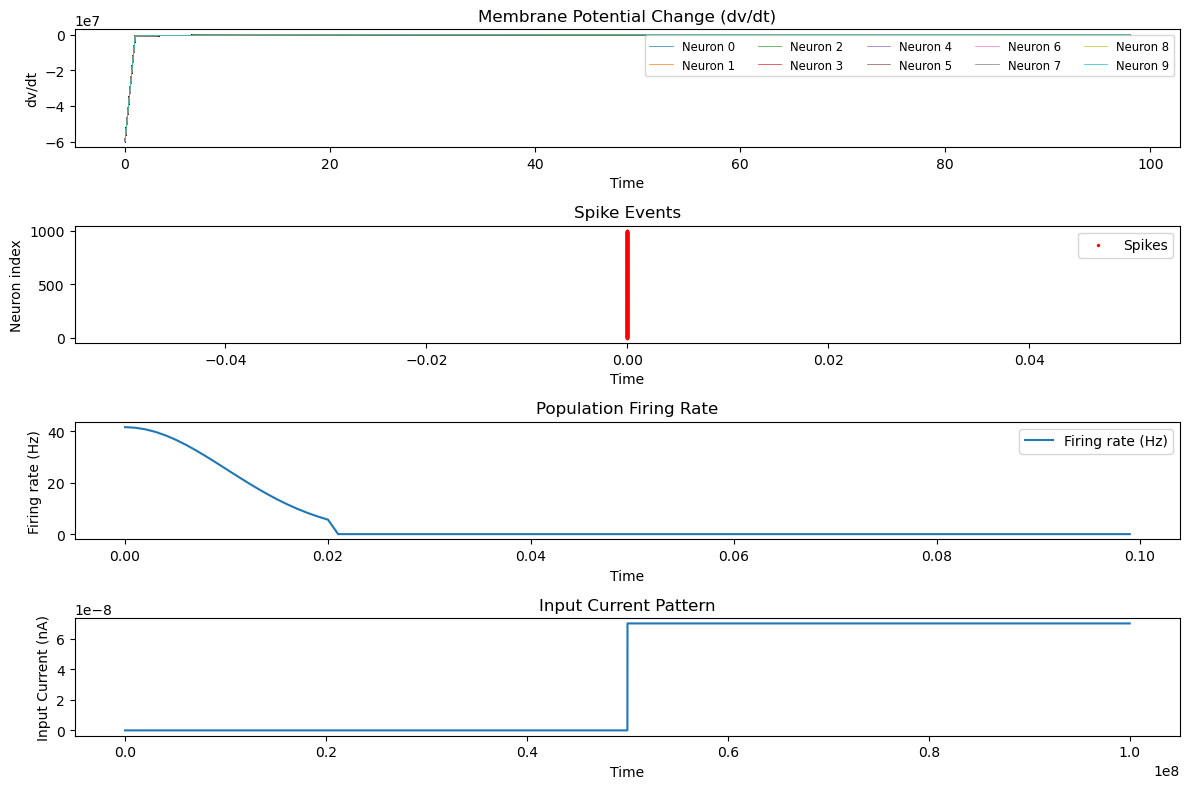

In [21]:
eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
# Create input pattern: constant then step change
I_base = 0 * nA
I_step = 70 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = 0 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / br.ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()

INFO:root:building '_cython_magic_2c13952f1a622a23bfaef53f279718e8' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_2c13952f1a622a23bfaef53f279718e8.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_2c13952f1a622a23bfaef53f279718e8.o -w

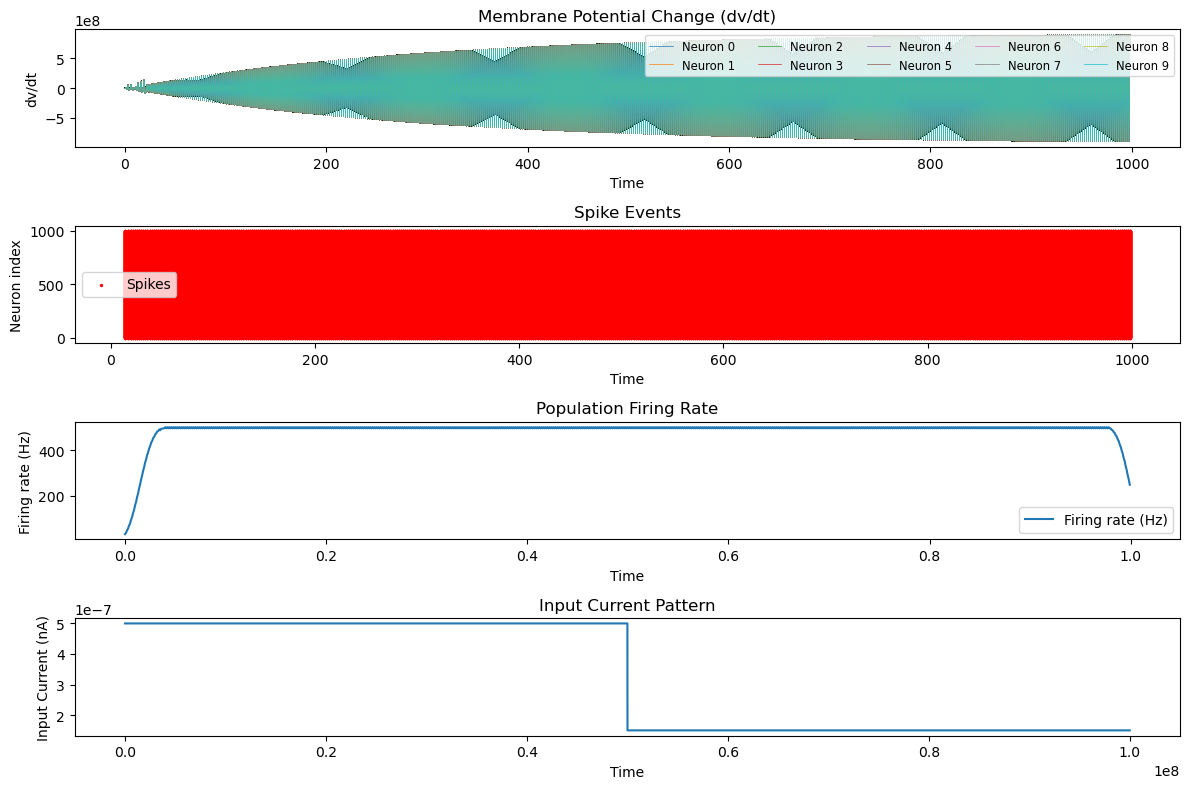

In [35]:
eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 1000 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
# Create input pattern: constant then step change
I_base = 500 * nA
I_step = 150 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.01 / br.ms
dSPN.b = -20 / ms
# dSPN.c = -55 * mV
dSPN.d = 91 * mV / ms
dSPN.k = 1
dSPN.vr = -80 * mV
dSPN.vt = -29.7 * mV
dSPN.vpeak = 40 * mV
C = 15.2 * pF
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()

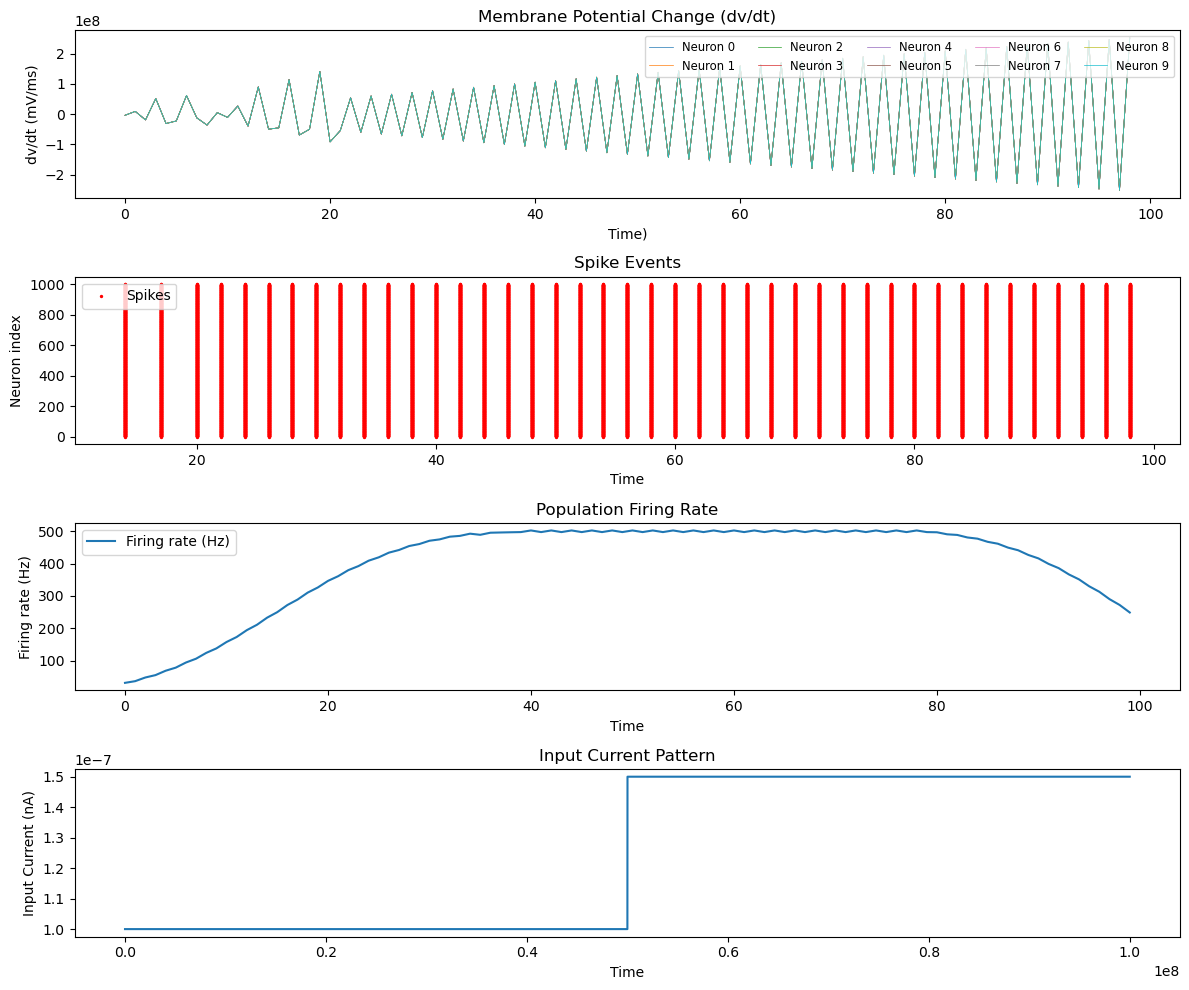

In [40]:
eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

# dSPN.run_regularly('v = rand()', dt = 1 * ms)
# Create input pattern: constant then step change
I_base = 100 * nA
I_step = 150 * nA
I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                   I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA
I_pattern = TimedArray(I_pattern_values, dt=defaultclock.dt)

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.01 / br.ms
dSPN.b = -20 / ms
# dSPN.c = -55 * mV
dSPN.d = 91 * mV / ms
dSPN.k = 1
dSPN.vr = -80 * mV
dSPN.vt = -29.7 * mV
dSPN.vpeak = 40 * mV
C = 15.2 * pF
# dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5
dSPN.run_regularly('I = I_pattern(t)', dt=defaultclock.dt)

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

plt.figure(figsize=(12, 10))

# Membrane potential change (dv/dt)
plt.subplot(4, 1, 1)
for i in range(10):  # Plotting dv/dt for first 10 neurons
    dv_dt = np.diff(dv_monitor.v[i]) / (dv_monitor.t[1] - dv_monitor.t[0])
    plt.plot(dv_monitor.t[:-1] / ms, dv_dt / mV * 1000, lw=0.5)
plt.xlabel('Time)')
plt.ylabel('dv/dt (mV/ms)')
plt.title('Membrane Potential Change (dv/dt)')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)

# Plot spikes
plt.subplot(4, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

# Plot input current pattern
plt.subplot(4, 1, 4)
input_times = np.arange(len(I_pattern_values)) * defaultclock.dt / ms
plt.plot(input_times, I_pattern_values / nA)
plt.xlabel('Time')
plt.ylabel('Input Current (nA)')
plt.title('Input Current Pattern')

plt.tight_layout()
plt.show()